In [1]:
import numpy as np
import pandas as pd
import math
import pickle

from tqdm.notebook import trange, tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
DATAFRAME_PATH = './data/labeled-comments.csv'
TF_QUANTITY = 100
GENERATE_TRAIN_TEST = False
MODELS_PATH = './data/models'

from utils import *

# Dataset details

In [3]:
df = pd.read_csv(DATAFRAME_PATH)
df

,comment_id,content,likes,dislikes,votes,avg,std,label,char-qty,word-qty
0,1489,MUITO MAIS LEGAL RRSRSRRSRSRS,2.0,0.0,2,0.000000,0.00000,0,30,5
1,273,Canhão de guerra.,2.0,4.0,2,1.000000,0.00000,1,18,4
2,2574,femi o que?,10.0,11.0,2,1.000000,0.00000,1,11,3
3,951,Concordo plenamente Jaqueline!! Outro dia ouvi...,20.0,0.0,3,0.666667,0.57735,1,161,27
4,2520,Feminista é uma mulher encalhada que precisa d...,11.0,11.0,3,1.000000,0.00000,1,66,11
...,...,...,...,...,...,...,...,...,...,...
3566,55,Brigue esquisitinha,0.0,1.0,3,0.666667,0.57735,1,19,2
3567,3858,"Pois é, todo o bozopata é assim! Depois que pe...",3.0,0.0,3,0.333333,0.57735,0,192,35
3568,3984,Será que ninguém tem coragem de enfrentar algu...,0.0,0.0,1,0.000000,NaN,0,368,60
3569,790,Perfeito!,2.0,2.0,3,0.333333,0.57735,0,9,1


In [4]:
df.describe()

,comment_id,likes,dislikes,votes,avg,std,label,char-qty,word-qty
count,3571.000000,3323.000000,3323.000000,3571.000000,3571.000000,2886.000000,3571.000000,3571.000000,3571.000000
mean,1923.082610,15.611496,9.856455,2.534304,0.523321,0.230954,0.523663,140.439373,24.494539
std,1135.048496,40.102726,41.783877,1.032327,0.420923,0.277073,0.499510,178.984760,27.111817
min,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,988.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,47.000000,9.000000
50%,1886.000000,5.000000,1.000000,3.000000,0.666667,0.000000,1.000000,94.000000,17.000000
75%,2783.500000,14.000000,6.000000,3.000000,1.000000,0.577350,1.000000,179.000000,32.000000
max,4283.000000,729.000000,1196.000000,7.000000,1.000000,0.577350,1.000000,7050.000000,819.000000


<div class="alert alert-info">
    <b>Dataset fields description</b>
    <hline/>
    <p><b>comment_id</b>: unique identifier to each comment from database</p>
    <p><b>content</b>: comment text content</p>
    <p><b>likes</b>: comment likes quantity</p>
    <p><b>dislikes</b>: comment dislikes quantity</p>
    <p><b>votes</b>: number of users that labeled the comment</p>
    <p><b>avg</b>: average of each vote value to the comment</p>
    <p><b>std</b>: standard deviation of each vote value to the comment</p>
    <p><b>label</b>: final label assigned to the comment, label 1 represents sexist comments and label 0 represets not sexist comments</p>
    <p><b>char-qty</b>: number of characters in the comment </p>
    <p><b>word-qty</b>: number of words in the comment</p>
</div>

<div class="alert alert-info">
A visual data analysis is avaliable at https://datastudio.google.com/s/sgO8X7JORMU
</div>

In [5]:
sexist_df = df[df['avg'] > 0.5]
not_sexist_df = df[df['avg'] < 0.5]

In [6]:
sexist_df.describe()

,comment_id,likes,dislikes,votes,avg,std,label,char-qty,word-qty
count,1870.000000,1751.000000,1751.000000,1870.000000,1870.000000,1534.000000,1870.0,1870.000000,1870.000000
mean,1858.650802,17.322102,13.040548,2.591444,0.896753,0.218061,1.0,144.170053,25.153476
std,1065.130683,38.991503,50.191155,1.054396,0.152431,0.273659,0.0,210.709060,30.106827
min,5.000000,0.000000,0.000000,1.000000,0.571429,0.000000,1.0,2.000000,1.000000
25%,1003.250000,2.000000,0.000000,2.000000,0.666667,0.000000,1.0,51.000000,9.000000
50%,1740.500000,6.000000,2.000000,3.000000,1.000000,0.000000,1.0,96.000000,17.000000
75%,2583.750000,15.500000,7.000000,3.000000,1.000000,0.577350,1.0,179.000000,31.750000
max,4280.000000,688.000000,1196.000000,7.000000,1.000000,0.577350,1.0,7050.000000,819.000000


In [7]:
not_sexist_df.describe()

,comment_id,likes,dislikes,votes,avg,std,label,char-qty,word-qty
count,1701.000000,1572.000000,1572.000000,1701.000000,1701.000000,1352.000000,1701.0,1701.000000,1701.000000
mean,1993.915932,13.706107,6.309796,2.471487,0.112788,0.245583,0.0,136.338036,23.770135
std,1203.590636,41.234254,29.355610,1.004070,0.156500,0.280281,0.0,135.758905,23.368218
min,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000,1.000000
25%,964.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.0,43.000000,8.000000
50%,1992.000000,4.000000,1.000000,3.000000,0.000000,0.000000,0.0,90.000000,16.000000
75%,2945.000000,12.000000,4.000000,3.000000,0.333333,0.577350,0.0,179.000000,32.000000
max,4283.000000,729.000000,842.000000,7.000000,0.400000,0.577350,0.0,950.000000,168.000000


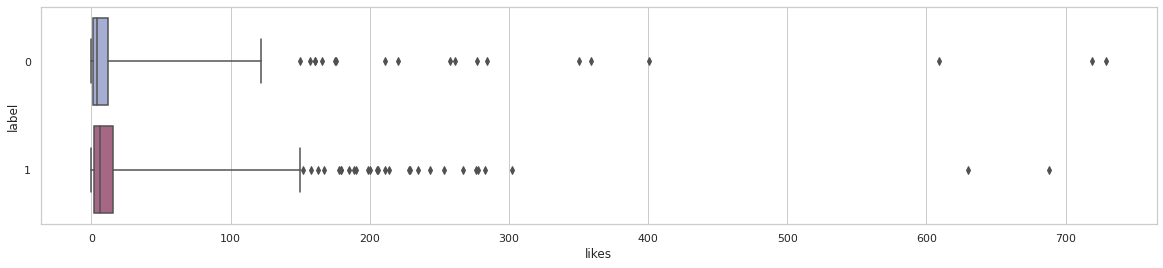

In [8]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(style="whitegrid", palette="pastel")

plot = df
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='likes', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

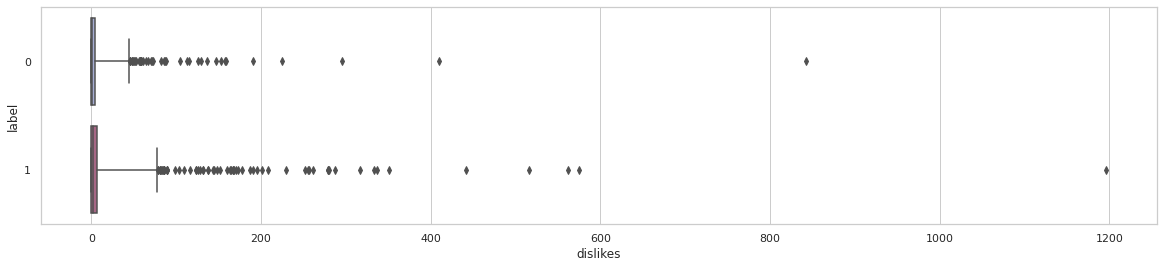

In [9]:
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='dislikes', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

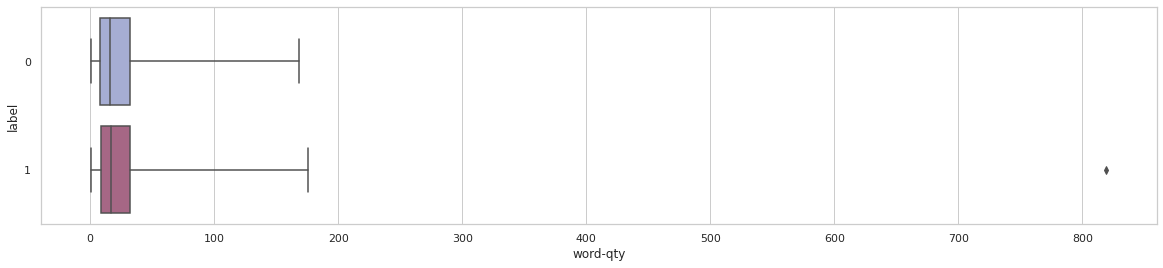

In [10]:
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='word-qty', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

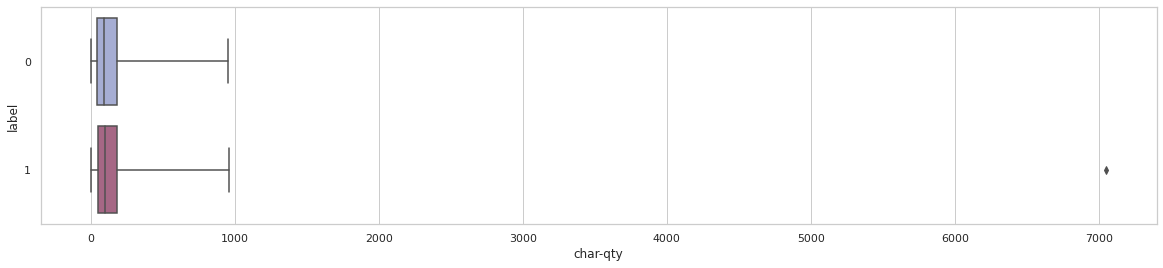

In [11]:
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='char-qty', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

# Training and testing models

In [ ]:
from sklearn.pipeline import make_pipeline
from joblib import parallel_backend
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



if GENERATE_TRAIN_TEST:
    generate_cross_validation_train_and_test(df)

results = []
for i in tqdm(range(0, 10)):
    # ------- loading data
    train = pd.read_csv(f'./data/{i+1}_train.csv')
    test = pd.read_csv(f'./data/{i+1}_test.csv')
    X_train = train.drop(columns=['sexist'])
    y_train = train['sexist']
    X_test = test.drop(columns=['sexist'])
    y_test = test['sexist']
    
    # ------- selection features combination
    feature_combinations = {
        'TFus' : [x for x in list(train.columns) if 'TFus' in x], # sexist unigrams TFs
        'TFun' : [x for x in list(train.columns) if 'TFun' in x], # not-sexist unigrams TFs
        'TFbs' : [x for x in list(train.columns) if 'TFbs' in x], # sexist bigrams TFs
        'TFbn' : [x for x in list(train.columns) if 'TFbn' in x], # not sexist bigrams TFs
        'L' : ['likes'], # likes quantity
        'D' : ['dislikes'], # dislikes quantity
        'CQ' : ['char-qty'], # chars quantity
        'WQ' : ['word-qty'] # word quantity
    }
    feature_combinations['CQWQ'] = feature_combinations['CQ'] + feature_combinations['WQ']
    feature_combinations['LD'] = feature_combinations['L'] + feature_combinations['D']
    feature_combinations['Q'] = feature_combinations['LD'] + feature_combinations['CQWQ']
    
    feature_combinations['TFu'] = feature_combinations['TFus'] + feature_combinations['TFun']
    feature_combinations['TFb'] = feature_combinations['TFbs'] + feature_combinations['TFbn']
    feature_combinations['TF'] = feature_combinations['TFu'] + feature_combinations['TFb']
    feature_combinations['TFuQ'] = feature_combinations['TFu'] + feature_combinations['Q']    
    
    combination_results = dict({})

    for combination in tqdm(feature_combinations.keys()):
        X_train_ = select_df_columns(X_train, feature_combinations[combination])
        X_test_ = select_df_columns(X_test, feature_combinations[combination])

        # ------ training SVM
        model_path = f'{MODELS_PATH}/{i}_SVM_{combination}'

        try:
            svm = pickle.load(open(model_path, 'rb'))
        except:
            svm = SVC(kernel='rbf', C=1.0, gamma='scale')
            with parallel_backend('threading', n_jobs=12):
                svm.fit(X_train_ ,y_train)
            pickle.dump(svm, open(model_path, 'wb'))

        # ------ testing SVM
        y = svm.predict(X_test_)
        precision, recall, fscore, _ = score(y_test, y, average=None, labels=[1, 0])
        report = build_results_report(f'{i}_SVM_{combination}', precision, recall, fscore, f1_score(y_test,y))
        combination_results[f'{i}_SVM_{combination}'] = report
        # print_report(report)

        # ------ training KNN
        model_path = f'{MODELS_PATH}/{i}_KNN_{combination}'
        try:
            knn = pickle.load(open(model_path, 'rb'))
        except:
            knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
            with parallel_backend('threading', n_jobs=12):
                knn.fit(X_train_,y_train)
            pickle.dump(knn, open(model_path, 'wb'))

        # ------ testing KNN
        y = knn.predict(X_test_)
        precision, recall, fscore, _ = score(y_test, y, average=None, labels=[1, 0])
        report = build_results_report(f'{i}_KNN_{combination}', precision, recall, fscore, f1_score(y_test,y))
        combination_results[f'{i}_KNN_{combination}'] = report
        # print_report(report)

        # ------ training RFC
        model_path = f'{MODELS_PATH}/{i}_RFC_{combination}'
        print(model_path)
        try:
            rfc = pickle.load(open(model_path, 'rb'))
        except:
            rfc = RandomForestClassifier(n_estimators=200, max_depth=8)
            with parallel_backend('threading', n_jobs=12):
                rfc.fit(X_train_,y_train)
            pickle.dump(rfc, open(model_path, 'wb'))
        # ------ testing RFC
        y = rfc.predict(X_test_)
        precision, recall, fscore, _ = score(y_test, y, average=None, labels=[1, 0])
        report = build_results_report(f'{i}_RFC_{combination}', precision, recall, fscore, f1_score(y_test,y))
        combination_results[f'{i}_RFC_{combination}'] = report
        # print_report(report)

    results.append(combination_results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

./data/models/0_RFC_TFus
./data/models/0_RFC_TFun
./data/models/0_RFC_TFbs
./data/models/0_RFC_TFbn
./data/models/0_RFC_L
./data/models/0_RFC_D
./data/models/0_RFC_CQ
./data/models/0_RFC_WQ
./data/models/0_RFC_CQWQ
./data/models/0_RFC_LD
./data/models/0_RFC_Q
./data/models/0_RFC_TFu
./data/models/0_RFC_TFb
./data/models/0_RFC_TF


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/0_RFC_TFuQ


  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/1_RFC_TFus


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/1_RFC_TFun


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/1_RFC_TFbs


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/1_RFC_TFbn


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/1_RFC_L
./data/models/1_RFC_D
./data/models/1_RFC_CQ
./data/models/1_RFC_WQ
./data/models/1_RFC_CQWQ
./data/models/1_RFC_LD
./data/models/1_RFC_Q


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/1_RFC_TFu


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/1_RFC_TFb


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/1_RFC_TF


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/1_RFC_TFuQ


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/2_RFC_TFus


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/2_RFC_TFun


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/2_RFC_TFbs


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/2_RFC_TFbn


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/2_RFC_L
./data/models/2_RFC_D
./data/models/2_RFC_CQ
./data/models/2_RFC_WQ
./data/models/2_RFC_CQWQ
./data/models/2_RFC_LD
./data/models/2_RFC_Q


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/2_RFC_TFu


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/2_RFC_TFb


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/2_RFC_TF


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/2_RFC_TFuQ


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/3_RFC_TFus


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/3_RFC_TFun


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/3_RFC_TFbs


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/3_RFC_TFbn


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/3_RFC_L
./data/models/3_RFC_D
./data/models/3_RFC_CQ
./data/models/3_RFC_WQ
./data/models/3_RFC_CQWQ
./data/models/3_RFC_LD
./data/models/3_RFC_Q


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/3_RFC_TFu


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/3_RFC_TFb


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/3_RFC_TF


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/3_RFC_TFuQ


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/4_RFC_TFus


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/4_RFC_TFun


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/4_RFC_TFbs


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/4_RFC_TFbn


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/4_RFC_L
./data/models/4_RFC_D
./data/models/4_RFC_CQ
./data/models/4_RFC_WQ
./data/models/4_RFC_CQWQ
./data/models/4_RFC_LD
./data/models/4_RFC_Q


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/4_RFC_TFu


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/4_RFC_TFb


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/4_RFC_TF


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This mi

./data/models/4_RFC_TFuQ


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/5_RFC_TFus


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/5_RFC_TFun


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/5_RFC_TFbs


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/5_RFC_TFbn


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/5_RFC_L
./data/models/5_RFC_D
./data/models/5_RFC_CQ
./data/models/5_RFC_WQ
./data/models/5_RFC_CQWQ
./data/models/5_RFC_LD
./data/models/5_RFC_Q


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/5_RFC_TFu


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/5_RFC_TFb


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/5_RFC_TF


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/5_RFC_TFuQ


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/6_RFC_TFus


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/6_RFC_TFun


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/6_RFC_TFbs


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/6_RFC_TFbn


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/6_RFC_L
./data/models/6_RFC_D
./data/models/6_RFC_CQ
./data/models/6_RFC_WQ
./data/models/6_RFC_CQWQ
./data/models/6_RFC_LD
./data/models/6_RFC_Q


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/6_RFC_TFu


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/6_RFC_TFb


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/6_RFC_TF


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/6_RFC_TFuQ


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/7_RFC_TFus


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/7_RFC_TFun


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This mi

./data/models/7_RFC_TFbs


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This mi

./data/models/7_RFC_TFbn


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


./data/models/7_RFC_L
./data/models/7_RFC_D
./data/models/7_RFC_CQ
./data/models/7_RFC_WQ
./data/models/7_RFC_CQWQ
./data/models/7_RFC_LD
./data/models/7_RFC_Q


/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/luisa.braga/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
pickle.dump(mean_results, open('./data/results','wb'))

# Computing results

In [ ]:
import re
final_results = dict({})
mean_results = dict({})

for result in results:
    for key in result.keys():
        final_key = re.sub('\d+_', '', key)
        if final_key not in final_results.keys():    
            final_results[final_key] = {
                'precision': {'1': [], '0': []},
                'recall': {'1': [], '0': []},
                'f1': {'1': [], '0': []},
                'f1_macro': []
            }

        current = result[key]
        final_results[final_key]['precision']['1'].append(current['precision']['1'][0])
        final_results[final_key]['precision']['0'].append(current['precision']['0'][0])
        final_results[final_key]['recall']['1'].append(current['recall']['1'][0])
        final_results[final_key]['recall']['0'].append(current['recall']['0'][0])
        final_results[final_key]['f1']['1'].append(current['f1']['1'][0])
        final_results[final_key]['f1']['0'].append(current['f1']['0'][0])
        final_results[final_key]['f1_macro'].append(current['f1_macro'][0])

In [ ]:
def med(array):
    return sum(array)/10

for key in final_results.keys():
    mean_results[key] = {
        'title': key,
        'precision': {'1': med(final_results[key]['precision']['1']),
                      '0': med(final_results[key]['precision']['0'])},
        'recall': {'1': med(final_results[key]['recall']['1']),
                      '0': med(final_results[key]['recall']['0'])},
        'f1': {'1': med(final_results[key]['f1']['1']),
                      '0': med(final_results[key]['f1']['0'])},
    }

In [ ]:
for key in mean_results.keys():
    if 'SVM' in key:
        print_report(mean_results[key])
        
for key in mean_results.keys():
    if 'KNN' in key:
        print_report(mean_results[key])
        
for key in mean_results.keys():
    if 'RFC' in key:
        print_report(mean_results[key])

# Wilcoxon

In [ ]:
final_results['BERT']= {'f1_macro': [
    0.571069182389937,
    0.45852187028657615,
    0.5364583333333334,
    0.5258964143426295,
    0.5313351498637601,
    0.4828571428571429,
    0.43333333333333335,
    0.5463659147869674,
    0.5493333333333332,
    0.5195822454308094
]}

final_results['B_SVM'] = {'f1_macro': [0.58, 0.6, 0.6, 0.6, 0.59, 0.59, 0.6, 0.6, 0.59, 0.6]}
final_results['B_LR']= {'f1_macro': [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]}

tests = dict({})
from scipy.stats import wilcoxon
for key_1 in final_results.keys():
    for key_2 in final_results.keys():
        if (key_1 != key_2) and \
            f'{key_1} x {key_2}' not in tests.keys() and\
            f'{key_2} x {key_1}' not in tests.keys():
            values_y = final_results[key_1]['f1_macro']
            values_x = final_results[key_2]['f1_macro']
            test_stat, test_p = wilcoxon(values_y, values_x)
            tests[f'{key_1} x {key_2}'] = test_p

In [ ]:
pickle.dump(tests, open('./data/wilcoxon', 'wb'))